## 1. Import Libraries and Load Data
In this section, we load the census tract shapefile and air quality monitor CSV data. 
We then convert the monitor CSV to a GeoDataFrame and check that both datasets are loaded correctly.

In [1]:
# Core numerical and data manipulation libraries
import numpy as np
import pandas as pd
import collections
from kneed import KneeLocator

# Visualization libraries
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import seaborn as sns
import folium

# Geospatial libraries
import geopandas as gpd
from shapely.geometry import Point, LineString

# Machine learning for spatial clustering
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from scipy.stats import boxcox

# Spatial statistical analysis
import libpysal
from esda import Moran, Moran_Local

# Network analysis and OSM data
import osmnx as ox
import networkx as nx

import warnings
warnings.filterwarnings("ignore", message="The weights matrix is not fully connected")
warnings.filterwarnings("ignore", message="The weights matrix is not symmetric")
warnings.filterwarnings("ignore", message="The weights matrix is not square")

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
# Set the plotting style
sns.set_style('whitegrid')
# Set the color palette
sns.set_palette('deep')
# Set the figure size for plots
plt.rcParams['figure.figsize'] = (10, 6)
# Set the font size for plots
plt.rcParams['font.size'] = 12
# Set the color palette for plots
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=sns.color_palette())
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.titlesize'] = 'large'
plt.rcParams['axes.labelsize'] = 'large'
# plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['axes.titlecolor'] = 'black'
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.titlepad'] = 10


# Load Census Tract shapefile
tracts = gpd.read_file('../data/raw/tl_2024_06_tract.zip')

# Load Air Quality Monitor CSV
monitors_df = pd.read_csv('../data/raw/annual_conc_by_monitor_2024.csv')

# Create GeoDataFrame for monitors, using Longitude and Latitude columns
monitors_gdf = gpd.GeoDataFrame(
    monitors_df, 
    geometry=gpd.points_from_xy(monitors_df['Longitude'], monitors_df['Latitude']),
    crs="EPSG:4326"
)

# Add a unique identifier for monitors if not present
monitors_gdf.reset_index(inplace=True)
monitors_gdf.rename(columns={'index': 'monitor_id'}, inplace=True)

print("Shape of tracts:", tracts.shape)
print("Shape of monitors:", monitors_gdf.shape)

Shape of tracts: (9129, 14)
Shape of monitors: (59175, 57)


## 2. Data Inspection: Geometry Complexity and Area Statistics
We inspect the census tract dataset to determine:
- Total number of features
- Geometry complexity (number of vertices per feature)
- Area statistics (min, max, average area in square kilometers)

### Basic Info

In [2]:
# Print high-level info about the GeoDataFrames
print("TRACTS INFO:")
tracts.info()
print("\nMONITORS INFO:")
monitors_gdf.info()

# Peek at a few rows
print("\nTRACTS HEAD:")
display(tracts.head(3))
print("\nMONITORS HEAD:")
display(monitors_gdf.head(3))

# If you want descriptive stats for numeric columns:
print("\nDescriptive Stats for MONITORS:")
display(monitors_gdf.describe(include='all'))

print("\nDescriptive Stats for TRACTS:")
display(tracts.describe(include='all'))

TRACTS INFO:
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 9129 entries, 0 to 9128
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   STATEFP   9129 non-null   object  
 1   COUNTYFP  9129 non-null   object  
 2   TRACTCE   9129 non-null   object  
 3   GEOID     9129 non-null   object  
 4   GEOIDFQ   9129 non-null   object  
 5   NAME      9129 non-null   object  
 6   NAMELSAD  9129 non-null   object  
 7   MTFCC     9129 non-null   object  
 8   FUNCSTAT  9129 non-null   object  
 9   ALAND     9129 non-null   int64   
 10  AWATER    9129 non-null   int64   
 11  INTPTLAT  9129 non-null   object  
 12  INTPTLON  9129 non-null   object  
 13  geometry  9129 non-null   geometry
dtypes: geometry(1), int64(2), object(11)
memory usage: 998.6+ KB

MONITORS INFO:
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 59175 entries, 0 to 59174
Data columns (total 57 columns):
 #   Column                      

,STATEFP,COUNTYFP,TRACTCE,GEOID,GEOIDFQ,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,06,001,442700,06001442700,1400000US06001442700,4427,Census Tract 4427,G5020,S,1234016,0,+37.5371513,-122.0081095,"POLYGON ((-122.01721 37.53932, -122.01719 37.5..."
1,06,001,442800,06001442800,1400000US06001442800,4428,Census Tract 4428,G5020,S,1278646,0,+37.5293619,-121.9931002,"POLYGON ((-122.0023 37.52984, -122.00224 37.52..."
2,06,037,204920,06037204920,1400000US06037204920,2049.20,Census Tract 2049.20,G5020,S,909972,0,+34.0175004,-118.1974975,"POLYGON ((-118.20284 34.01966, -118.20283 34.0..."



MONITORS HEAD:


,monitor_id,State Code,County Code,Site Num,Parameter Code,POC,Latitude,Longitude,Datum,Parameter Name,Sample Duration,Pollutant Standard,Metric Used,Method Name,Year,Units of Measure,Event Type,Observation Count,Observation Percent,Completeness Indicator,Valid Day Count,Required Day Count,Exceptional Data Count,Null Data Count,Primary Exceedance Count,Secondary Exceedance Count,Certification Indicator,Num Obs Below MDL,Arithmetic Mean,Arithmetic Standard Dev,1st Max Value,1st Max DateTime,2nd Max Value,2nd Max DateTime,3rd Max Value,3rd Max DateTime,4th Max Value,4th Max DateTime,1st Max Non Overlapping Value,1st NO Max DateTime,2nd Max Non Overlapping Value,2nd NO Max DateTime,99th Percentile,98th Percentile,95th Percentile,90th Percentile,75th Percentile,50th Percentile,10th Percentile,Local Site Name,Address,State Name,County Name,City Name,CBSA Name,Date of Last Change,geometry
0,0,1,3,10,44201,1,30.497478,-87.880258,NAD83,Ozone,1 HOUR,Ozone 1-hour 1979,Daily maxima of observed hourly values (betwee...,INSTRUMENTAL - ULTRA VIOLET ABSORPTION,2024,Parts per million,No Events,3346,58,N,143,245,0,326,0.0,0.0,Certification not required,0,0.044385,0.011103,0.073,2024-06-08 14:00,0.066,2024-04-05 15:00,0.063,2024-03-06 01:00,0.062,2024-03-01 01:00,NaN,NaN,NaN,NaN,0.066,0.063,0.061,0.058,0.053,0.046,0.030,"FAIRHOPE, Alabama","FAIRHOPE HIGH SCHOOL, 1 PIRATE DRIVE, FAIRHOPE...",Alabama,Baldwin,Fairhope,"Daphne-Fairhope-Foley, AL",2024-10-31,POINT (-87.88026 30.49748)
1,1,1,3,10,44201,1,30.497478,-87.880258,NAD83,Ozone,8-HR RUN AVG BEGIN HOUR,Ozone 8-Hour 1997,Daily maximum of 8 hour running average of obs...,NaN,2024,Parts per million,No Events,6948,60,N,147,245,0,0,0.0,0.0,Certification not required,0,0.038857,0.009977,0.065,2024-06-08 10:00,0.060,2024-04-05 10:00,0.056,2024-06-09 09:00,0.054,2024-05-29 11:00,NaN,NaN,NaN,NaN,0.060,0.056,0.053,0.051,0.047,0.040,0.025,"FAIRHOPE, Alabama","FAIRHOPE HIGH SCHOOL, 1 PIRATE DRIVE, FAIRHOPE...",Alabama,Baldwin,Fairhope,"Daphne-Fairhope-Foley, AL",2024-10-31,POINT (-87.88026 30.49748)
2,2,1,3,10,44201,1,30.497478,-87.880258,NAD83,Ozone,8-HR RUN AVG BEGIN HOUR,Ozone 8-Hour 2008,Daily maximum of 8 hour running average of obs...,NaN,2024,Parts per million,No Events,6948,60,N,147,245,0,0,0.0,0.0,Certification not required,0,0.038857,0.009977,0.065,2024-06-08 10:00,0.060,2024-04-05 10:00,0.056,2024-06-09 09:00,0.054,2024-05-29 11:00,NaN,NaN,NaN,NaN,0.060,0.056,0.053,0.051,0.047,0.040,0.025,"FAIRHOPE, Alabama","FAIRHOPE HIGH SCHOOL, 1 PIRATE DRIVE, FAIRHOPE...",Alabama,Baldwin,Fairhope,"Daphne-Fairhope-Foley, AL",2024-10-31,POINT (-87.88026 30.49748)



Descriptive Stats for MONITORS:


,monitor_id,State Code,County Code,Site Num,Parameter Code,POC,Latitude,Longitude,Datum,Parameter Name,Sample Duration,Pollutant Standard,Metric Used,Method Name,Year,Units of Measure,Event Type,Observation Count,Observation Percent,Completeness Indicator,Valid Day Count,Required Day Count,Exceptional Data Count,Null Data Count,Primary Exceedance Count,Secondary Exceedance Count,Certification Indicator,Num Obs Below MDL,Arithmetic Mean,Arithmetic Standard Dev,1st Max Value,1st Max DateTime,2nd Max Value,2nd Max DateTime,3rd Max Value,3rd Max DateTime,4th Max Value,4th Max DateTime,1st Max Non Overlapping Value,1st NO Max DateTime,2nd Max Non Overlapping Value,2nd NO Max DateTime,99th Percentile,98th Percentile,95th Percentile,90th Percentile,75th Percentile,50th Percentile,10th Percentile,Local Site Name,Address,State Name,County Name,City Name,CBSA Name,Date of Last Change,geometry
count,59175.000000,59175.000000,59175.000000,59175.000000,59175.000000,59175.000000,59175.000000,59175.000000,59175,59175,59175,20782,59175,46207,59175.0,59175,59175,59175.000000,59175.000000,59175,59175.000000,59175.000000,59175.000000,59175.000000,13922.000000,13100.000000,59175,59175.0,59171.000000,59171.000000,59175.000000,59175,59034.000000,59034,58993.000000,58993,58890.000000,58890,227.000000,227,227.000000,227,59171.000000,59171.000000,59170.000000,59167.000000,59138.000000,59004.000000,58609.000000,54852,59174,59175,59175,46909,53228,59175,59175
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,423,12,23,13,363,NaN,27,4,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,4376,NaN,4595,NaN,4747,NaN,4792,NaN,177,NaN,191,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2109,2284,54,793,1169,519,149,2286
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WGS84,PM2.5 - Local Conditions,24 HOUR,PM25 Annual 2024,Observed Values,IMPROVE Module A with Cyclone Inlet-Teflon Fil...,NaN,Micrograms/cubic meter (LC),No Events,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,Certification not required,NaN,NaN,NaN,NaN,2024-01-01 00:00,NaN,2024-01-07 00:00,NaN,2024-01-07 00:00,NaN,2024-01-19 00:00,NaN,2024-01-01 05:00,NaN,2024-01-01 05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,JLG SUPERSITE,4530 N 17TH AVENUE,California,Jefferson,Phoenix,"New York-Newark-Jersey City, NY-NJ-PA",2024-11-06,POINT (-112.095767 33.503833)
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43552,13165,32546,1520,38936,3528,NaN,30974,57876,NaN,NaN,56251,NaN,NaN,NaN,NaN,NaN,NaN,59175,NaN,NaN,NaN,NaN,6469,NaN,2877,NaN,2614,NaN,3174,NaN,14,NaN,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,549,549,6680,1214,748,1581,11761,549
mean,29587.000000,28.088602,73.525357,1191.394880,69761.874626,3.236232,38.622878,-95.654163,NaN,NaN,NaN,NaN,NaN,NaN,2024.0,NaN,NaN,1850.668695,46.389742,NaN,103.312886,205.487283,20.138285,66.902357,2.339894,2.106183,NaN,0.0,31.480755,6.489238,69.159261,NaN,62.806735,NaN,59.246745,NaN,57.353077,NaN,1.030396,NaN,0.900441,NaN,50.248599,47.248379,42.951924,39.670918,34.639475,30.577480,25.001765,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,17082.495427,16.798479,84.287382,2495.930435,21479.526684,6.297101,5.709113,17.802567,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,4939.563822,20.837896,NaN,91.623118,136.197055,596.343089,442.781656,9.703631,9.533790,NaN,0.0,263.549641,172.200569,1401.725505,NaN,1346.464805,NaN,1233.094569,NaN,1193.540569,NaN,0.671942,NaN,0.555941,NaN,819.161544,726.152708,581.891367,477.896143,330.283814,227.975675,151.792531,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.000000,1.000000,1.000000,1.000000,11101.000000,1.000000,17.955378,-160.508331,NaN,NaN,NaN,NaN,NaN,NaN,2024.0,NaN,NaN,1.000000,0.000000,NaN,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.0,-8.786395,0.000000,-0.000940,NaN,-0.100000,NaN,-0.400000,NaN,-1.800000,NaN,0.000000,NaN,0.000000,NaN,-0.100000,-0.600000,-0.900000,-1.400000,-2.100000,-8.100000,-42.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,14793.500000,12.000000,21.000000,8.000000,44201.000000,1.000000,35.041416,-111.329500,NaN,NaN,NaN,NaN,NaN,NaN,2024.0,NaN,NaN,26.000000,34.000000,NaN,25.000000,61.000000,0.000000,0.000000,0.000000,0.00


Descriptive Stats for TRACTS:


,STATEFP,COUNTYFP,TRACTCE,GEOID,GEOIDFQ,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
count,9129,9129,9129,9129,9129,9129,9129,9129,9129,9.129000e+03,9.129000e+03,9129,9129,9129
unique,1,58,7369,9129,9129,7369,7369,1,1,NaN,NaN,9129,9128,9129
top,06,037,000400,06001442700,1400000US06001442700,4,Census Tract 4,G5020,S,NaN,NaN,+37.5371513,-121.2192849,"POLYGON ((-122.017211 37.539323, -122.017186 3..."
freq,9129,2498,16,1,1,16,16,9129,9129,NaN,NaN,1,2,1
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.421880e+07,2.222766e+06,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.892208e+08,3.969855e+07,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,0.000000e+00,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.651780e+05,0.000000e+00,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.764528e+06,0.000000e+00,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.213051e+06,5.937000e+03,NaN,NaN,NaN


### Missing Values

In [3]:
# Count missing values in each column
print("Missing values in tracts:")
print(tracts.isna().sum())

print("\nMissing values in monitors_gdf:")
print(monitors_gdf.isna().sum())

Missing values in tracts:
STATEFP     0
COUNTYFP    0
TRACTCE     0
GEOID       0
GEOIDFQ     0
NAME        0
NAMELSAD    0
MTFCC       0
FUNCSTAT    0
ALAND       0
AWATER      0
INTPTLAT    0
INTPTLON    0
geometry    0
dtype: int64

Missing values in monitors_gdf:
monitor_id                           0
State Code                           0
County Code                          0
Site Num                             0
Parameter Code                       0
POC                                  0
Latitude                             0
Longitude                            0
Datum                                0
Parameter Name                       0
Sample Duration                      0
Pollutant Standard               38393
Metric Used                          0
Method Name                      12968
Year                                 0
Units of Measure                     0
Event Type                           0
Observation Count                    0
Observation Percent           

### Pollutant Details

In [4]:
target_pollutant = "Ozone"  # or "PM2.5 - Local Conditions"
subset = monitors_gdf[monitors_gdf["Parameter Name"] == target_pollutant]
print(f"\nNumber of rows for {target_pollutant}:", len(subset))
display(subset.describe())


Number of rows for Ozone: 4924


,monitor_id,State Code,County Code,Site Num,Parameter Code,POC,Latitude,Longitude,Year,Observation Count,Observation Percent,Valid Day Count,Required Day Count,Exceptional Data Count,Null Data Count,Primary Exceedance Count,Secondary Exceedance Count,Num Obs Below MDL,Arithmetic Mean,Arithmetic Standard Dev,1st Max Value,2nd Max Value,3rd Max Value,4th Max Value,1st Max Non Overlapping Value,2nd Max Non Overlapping Value,99th Percentile,98th Percentile,95th Percentile,90th Percentile,75th Percentile,50th Percentile,10th Percentile
count,4924.000000,4924.000000,4924.000000,4924.000000,4924.0,4924.000000,4924.000000,4924.000000,4924.0,4924.000000,4924.000000,4924.000000,4924.000000,4924.000000,4924.000000,4924.000000,4924.000000,4924.0,4920.000000,4920.000000,4924.000000,4924.000000,4924.000000,4924.000000,0.0,0.0,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.00000,4920.000000
mean,29186.794070,27.677498,76.896832,1246.043867,44201.0,1.090983,37.935065,-94.302094,2024.0,8440.589968,62.739846,177.268075,288.585500,20.323924,75.627132,1.074127,1.074127,0.0,0.044851,0.009747,0.072676,0.068777,0.066576,0.065092,NaN,NaN,0.068276,0.065409,0.061128,0.057358,0.051337,0.04485,0.033955
std,16723.971118,16.541639,81.922422,2557.404411,0.0,0.353515,4.894019,15.908891,0.0,8090.633017,19.613106,56.820696,64.966891,324.559715,232.014188,5.309284,5.309284,0.0,0.005570,0.002549,0.016251,0.013459,0.010961,0.010274,NaN,NaN,0.012172,0.011018,0.008592,0.007668,0.006512,0.00538,0.005700
min,0.000000,1.000000,1.000000,1.000000,44201.0,1.000000,18.216038,-158.088613,2024.0,83.000000,0.000000,0.000000,153.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.016083,0.003170,0.033000,0.032000,0.030000,0.029000,NaN,NaN,0.032000,0.029000,0.027000,0.025000,0.022000,0.01800,0.000000
25%,14526.750000,12.000000,21.000000,6.000000,44201.0,1.000000,34.615367,-108.218300,2024.0,4161.000000,49.000000,122.000000,245.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.041816,0.008246,0.065000,0.062000,0.060000,0.059000,NaN,NaN,0.062000,0.060000,0.056000,0.053000,0.048000,0.04200,0.031000
50%,29275.500000,27.000000,57.000000,22.000000,44201.0,1.000000,38.706080,-90.226488,2024.0,5764.500000,59.000000,181.000000,245.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.044766,0.009482,0.071000,0.067000,0.066000,0.064000,NaN,NaN,0.067000,0.065000,0.060000,0.057000,0.051000,0.04500,0.035000
75%,43875.250000,42.000000,105.000000,1008.000000,44201.0,1.000000,41.353620,-81.840900,2024.0,9584.000000,81.000000,214.000000,366.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.047921,0.010768,0.078000,0.074000,0.071000,0.070000,NaN,NaN,0.073000,0.070000,0.065000,0.061000,0.054250,0.04800,0.038000
max,59174.000000,80.000000,800.000000,9997.000000,44201.0,6.000000,64.845690,-66.150615,2024.0,103776.000000,100.000000,305.000000,366.000000,7179.000000,3662.000000,85.000000,85.000000,0.0,0.072019,0.067459,0.476000,0.411000,0.230000,0.137000,NaN,NaN,0.458000,0.411000,0.127000,0.113000,0.097000,0.06800,0.056000


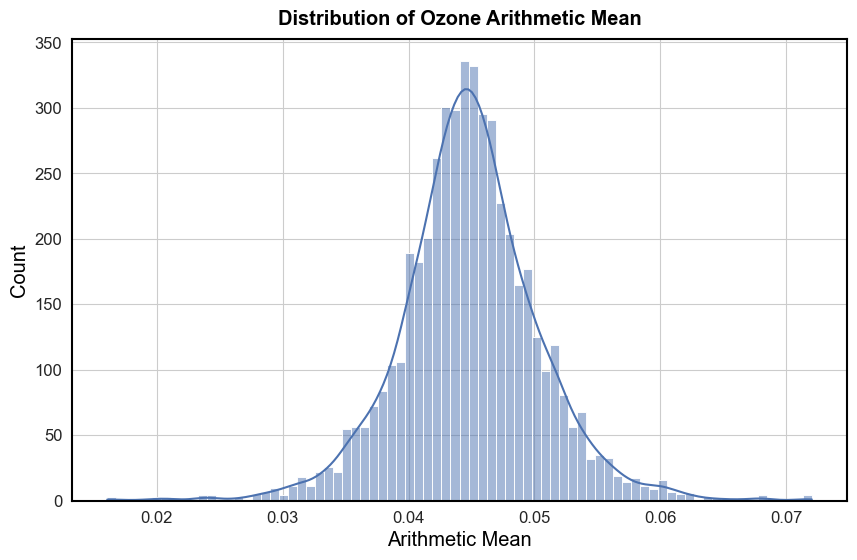

In [5]:
sns.histplot(data=subset, x="Arithmetic Mean", kde=True)
plt.title(f"Distribution of {target_pollutant} Arithmetic Mean")
plt.show()

### Coordinate Reference Systems (CRS)

In [6]:
# Convert tracts to EPSG:4326 (WGS84) for consistency in some operations
tracts_filtered_wgs = tracts.to_crs(epsg=4326)

# 1. Number of features
num_features = len(tracts_filtered_wgs)
print("Number of features in tracts_filtered_wgs:", num_features)

# 2. Geometry Complexity
def count_vertices(geom):
    """Count number of vertices in a geometry (for Polygon or MultiPolygon)."""
    if geom.geom_type == 'Polygon':
        return len(geom.exterior.coords)
    elif geom.geom_type == 'MultiPolygon':
        return sum(len(part.exterior.coords) for part in geom.geoms)
    else:
        return 0

tracts_filtered_wgs['num_vertices'] = tracts_filtered_wgs.geometry.apply(count_vertices)
avg_vertices = tracts_filtered_wgs['num_vertices'].mean()
min_vertices = tracts_filtered_wgs['num_vertices'].min()
max_vertices = tracts_filtered_wgs['num_vertices'].max()
print("\nGeometry Complexity (vertices per feature):")
print(f" - Average vertices: {avg_vertices:.2f}")
print(f" - Minimum vertices: {min_vertices}")
print(f" - Maximum vertices: {max_vertices}")

# 3. Area Statistics
# Reproject tracts to EPSG:3310 (California Albers Equal Area) for accurate area calculation
tracts_proj = tracts.to_crs(epsg=3310)
tracts_filtered_wgs['area_sq_km'] = tracts_proj.geometry.area / 1e6  # area in sq km

min_area = tracts_filtered_wgs['area_sq_km'].min()
max_area = tracts_filtered_wgs['area_sq_km'].max()
avg_area = tracts_filtered_wgs['area_sq_km'].mean()
print("\nCensus Tract Area (sq km) Statistics:")
print(f" - Minimum area: {min_area:.2f} sq km")
print(f" - Maximum area: {max_area:.2f} sq km")
print(f" - Average area: {avg_area:.2f} sq km")

print("\nMonitors CRS:", monitors_gdf.crs)
print("tracts_filtered_wgs CRS:", tracts_filtered_wgs.crs)

# Inspect a few rows of each dataset
print("Number of census tracts loaded:", len(tracts))
print("Number of monitors loaded:", len(monitors_gdf))

Number of features in tracts_filtered_wgs: 9129

Geometry Complexity (vertices per feature):
 - Average vertices: 348.40
 - Minimum vertices: 6
 - Maximum vertices: 11333

Census Tract Area (sq km) Statistics:
 - Minimum area: 0.02 sq km
 - Maximum area: 18011.44 sq km
 - Average area: 46.44 sq km

Monitors CRS: EPSG:4326
tracts_filtered_wgs CRS: EPSG:4326
Number of census tracts loaded: 9129
Number of monitors loaded: 59175


## Filtering and Cleaning

### Invalid Geometry or Duplicates

In [7]:
# Drop any rows with missing geometry in monitors
monitors_gdf = monitors_gdf[monitors_gdf.geometry.notna()].copy()

# Drop duplicates if needed (e.g., duplicates in monitor ID + geometry)
monitors_gdf.drop_duplicates(subset=["monitor_id", "Latitude", "Longitude"], inplace=True)

### Out-of-Range Coordinates

In [8]:
mask_valid_coords = (
    (monitors_gdf.geometry.y >= -90) & (monitors_gdf.geometry.y <= 90) &
    (monitors_gdf.geometry.x >= -180) & (monitors_gdf.geometry.x <= 180)
)
monitors_gdf = monitors_gdf[mask_valid_coords].copy()

## Column Selection and Renaming

In [9]:
# Example: Keep only certain columns
cols_to_keep = [
    "monitor_id", "State Code", "County Code", "Site Num", "Parameter Name",
    "Year", "Units of Measure", "Arithmetic Mean", "Latitude", "Longitude",
    "geometry"
]
monitors_gdf = monitors_gdf[cols_to_keep].copy()

# Optional: Rename columns for clarity
monitors_gdf.rename(columns={
    "Arithmetic Mean": "value_mean",
    "Parameter Name": "pollutant_name"
}, inplace=True)

## Pollutant-Specific Preprocessing

In [10]:
# Filter for Ozone monitors
ozone_gdf = monitors_gdf[monitors_gdf["pollutant_name"] == "Ozone"].copy()
ozone_gdf.info()

# If you want a certain year or range of years, filter further
ozone_gdf = ozone_gdf[ozone_gdf["Year"] == 2024]  

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 4924 entries, 0 to 59174
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   monitor_id        4924 non-null   int64   
 1   State Code        4924 non-null   int64   
 2   County Code       4924 non-null   int64   
 3   Site Num          4924 non-null   int64   
 4   pollutant_name    4924 non-null   object  
 5   Year              4924 non-null   int64   
 6   Units of Measure  4924 non-null   object  
 7   value_mean        4920 non-null   float64 
 8   Latitude          4924 non-null   float64 
 9   Longitude         4924 non-null   float64 
 10  geometry          4924 non-null   geometry
dtypes: float64(3), geometry(1), int64(5), object(2)
memory usage: 461.6+ KB


### Handling Missing or Zero Values

In [11]:
# Drop or fill missing values
ozone_gdf = ozone_gdf[ozone_gdf["value_mean"].notna()].copy()

# If you suspect zeros are invalid, filter them out:
ozero_mask = ozone_gdf["value_mean"] > 0.0
ozone_gdf = ozone_gdf[ozero_mask].copy()

### Removing Outliers

In [12]:
# Remove top/bottom 1% of values
low_cut = ozone_gdf["value_mean"].quantile(0.01)
high_cut = ozone_gdf["value_mean"].quantile(0.99)
mask_outliers = (ozone_gdf["value_mean"] >= low_cut) & (ozone_gdf["value_mean"] <= high_cut)
ozone_gdf = ozone_gdf[mask_outliers].copy()

### Transformations

In [13]:
# Box-Cox transform
ozone_boxcox, lambda_ = boxcox(ozone_gdf["value_mean"])
ozone_gdf["value_boxcox"] = ozone_boxcox
print("Box-Cox lambda:", lambda_)

Box-Cox lambda: 0.8534129259982066


## Spatial Join & Mapping

In this step, we integrate the air quality monitor data with census tract polygons and visualize the spatial distribution of pollution. We will:
- Spatially join air quality monitor points to their containing census tracts.
- Aggregate pollutant metrics per tract, using ozone (O₃).
- Visualize the data with a static choropleth map (using Matplotlib) and an interactive map (using Folium), and save the interactive map as an HTML file.

### Spatial Join of Monitors to Census Tracts

In [14]:
# Ensure both GeoDataFrames have the same CRS (project if necessary)
# Make sure 'ozone_gdf' uses the same CRS as 'tracts'
ozone_gdf = ozone_gdf.to_crs(tracts.crs)

# Perform spatial join: assign each monitor the attributes of the tract it falls in
# Spatially join the Ozone monitors to census tracts
ozone_in_tracts = gpd.sjoin(
    ozone_gdf,      # your preprocessed Ozone data
    tracts,         # the census tract polygons
    how='inner',    # only keep monitors that fall inside a tract
    predicate='intersects'
)

print(f"Joined Ozone records: {len(ozone_in_tracts)}")
display(ozone_in_tracts.head(3))

Joined Ozone records: 526


,monitor_id,State Code,County Code,Site Num,pollutant_name,Year,Units of Measure,value_mean,Latitude,Longitude,geometry,value_boxcox,index_right,STATEFP,COUNTYFP,TRACTCE,GEOID,GEOIDFQ,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON
3706,3706,6,1,7,Ozone,2024,Parts per million,0.034120,37.687526,-121.784217,POINT (-121.78422 37.68753),-1.106168,8539,06,001,451404,06001451404,1400000US06001451404,4514.04,Census Tract 4514.04,G5020,S,1675247,0,+37.6852758,-121.7803514
3726,3726,6,1,9,Ozone,2024,Parts per million,0.033333,37.743065,-122.169935,POINT (-122.16994 37.74306),-1.107461,3183,06,001,409300,06001409300,1400000US06001409300,4093,Census Tract 4093,G5020,S,1076042,0,+37.7378474,-122.1733603
3750,3750,6,1,11,Ozone,2024,Parts per million,0.033817,37.814781,-122.282347,POINT (-122.28235 37.81478),-1.106665,5783,06,001,402400,06001402400,1400000US06001402400,4024,Census Tract 4024,G5020,S,337011,0,+37.8120305,-122.2824576


### Aggregating Pollutant Metrics per Tract

In [15]:
grouped = ozone_in_tracts.groupby('GEOID')['value_mean'].mean().reset_index()

# Rename the aggregated column to 'Ozone' for clarity
grouped.rename(columns={'value_mean': 'Ozone'}, inplace=True)

print("Aggregated Ozone data (first few rows):")
display(grouped.head(5))

Aggregated Ozone data (first few rows):


,GEOID,Ozone
0,06001402400,0.033817
1,06001409300,0.033333
2,06001435103,0.034039
3,06001451401,0.035776
4,06001451404,0.034120


In [16]:
# Make a copy of tracts for clarity
tracts_ozone = tracts.copy()

# Merge on the 'GEOID' column
tracts_ozone = tracts_ozone.merge(grouped, on='GEOID', how='left')

# Check how many tracts got Ozone data
num_ozone = tracts_ozone['Ozone'].notna().sum()
print(f"Tracts with Ozone data: {num_ozone} / {len(tracts_ozone)}")

Tracts with Ozone data: 140 / 9129


### Static Map of Pollutant Levels by Tract

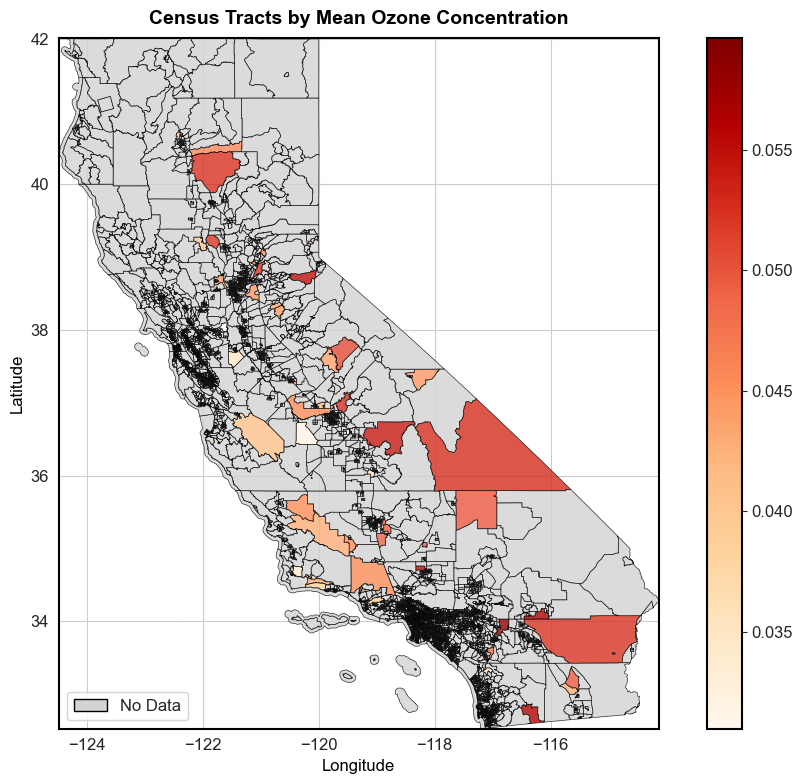

In [17]:
# Ensure 'tracts_ozone' is in EPSG:4326 if you want lat/lon plotting
tracts_ozone = tracts_ozone.to_crs(epsg=4326)

fig, ax = plt.subplots(figsize=(10, 8))

# Plot tracts colored by 'Ozone' column
tracts_ozone.plot(
    column='Ozone',
    cmap='OrRd',
    legend=True,
    ax=ax,
    edgecolor='black',
    linewidth=0.5,
    alpha=0.8,
    missing_kwds={
        "color": "lightgrey",
        "edgecolor": "black",
        "hatch": "",
        "label": "No Data"
    }
)

ax.set_title("Census Tracts by Mean Ozone Concentration", fontsize=14)
ax.set_xlabel("Longitude", fontsize=12)
ax.set_ylabel("Latitude", fontsize=12)

# Force the axes to show the full extent of the data
minx, miny, maxx, maxy = tracts_ozone.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Create a custom legend entry for missing data
missing_patch = mpatches.Patch(facecolor="lightgrey", edgecolor="black", label="No Data")
ax.legend(handles=[missing_patch], loc='lower left', fontsize=12)

plt.tight_layout()
plt.show()

### Interactive Map with Folium

In [18]:
# Center the map roughly over California
m = folium.Map(location=[36.77, -119.42], zoom_start=6)

# Convert 'tracts_ozone' to GeoJSON for Folium
# We'll drop rows with no geometry or Ozone for clarity
tracts_for_folium = tracts_ozone.dropna(subset=['Ozone', 'geometry']).copy()

# Add the choropleth
folium.Choropleth(
    geo_data=tracts_for_folium,
    name="Ozone",
    data=tracts_for_folium,
    columns=["GEOID", "Ozone"],
    key_on="feature.properties.GEOID",
    fill_color="YlOrRd",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Mean Ozone Concentration"
).add_to(m)

folium.LayerControl().add_to(m)
m.save("../maps/ozone_map.html")
m

FileNotFoundError: [Errno 2] No such file or directory: 'maps/ozone_map.html'

## Spatial Clustering of Air Quality Monitors

### Determining the Optimal Epsilon (ε) with k-Distance Graph

In [ ]:
# 1) Ensure both Ozone data and tracts share the same CRS
ozone_gdf = ozone_gdf.to_crs(tracts.crs)

# 2) Spatially join Ozone monitors with census tracts
ozone_in_tracts = gpd.sjoin(
    ozone_gdf, 
    tracts, 
    how='inner', 
    predicate='intersects'
)

print(f"Number of Ozone monitors after join: {len(ozone_in_tracts)}")
display(ozone_in_tracts.head(3))

# Option A: Use the original 'value_mean' for Ozone
# ozone_in_tracts['Ozone'] = ozone_in_tracts['value_mean']

# Option B: Use your log transform or Box-Cox transform instead
# ozone_in_tracts['Ozone'] = ozone_in_tracts['value_log']
ozone_in_tracts['Ozone'] = ozone_in_tracts['value_boxcox']

# Drop any rows with missing Ozone
ozone_in_tracts = ozone_in_tracts[ozone_in_tracts['Ozone'].notna()].copy()

# Extract coordinate arrays (make sure the geometry is still in a projected or lat/lon CRS)
coords = np.array(list(zip(ozone_in_tracts.geometry.x, ozone_in_tracts.geometry.y)))

# Combine coordinates + Ozone values into a single feature matrix X
ozone_vals = ozone_in_tracts['Ozone'].values
X = np.column_stack([coords, ozone_vals])

print("Feature matrix shape:", X.shape)

k = 5  # If min_samples=6, then k=5 for the k-distance
nbrs = NearestNeighbors(n_neighbors=k).fit(X)
distances, indices = nbrs.kneighbors(X)
kth_distances = np.sort(distances[:, k-1])

plt.figure(figsize=(6,4))
plt.plot(kth_distances)
plt.title(f"{k}-distance graph for DBSCAN")
plt.xlabel("Point (sorted by distance to 5th neighbor)")
plt.ylabel(f"Distance to {k}th nearest neighbor")
plt.show()

### Applying DBSCAN Clustering

In [ ]:
# Choose epsilon based on the k-distance elbow, e.g., eps=0.5
eps_opt = 0.52
min_pts = 6

db = DBSCAN(eps=eps_opt, min_samples=min_pts)
labels = db.fit_predict(X)

ozone_in_tracts['cluster'] = labels
num_clusters = len(set(labels) - {-1})
noise_points = list(labels).count(-1)

print(f"DBSCAN identified {num_clusters} clusters")
print(f"Noise points (outliers): {noise_points}")

cluster_counts = pd.Series(labels).value_counts().sort_index()
print("Cluster sizes:", cluster_counts.to_dict())

### Mapping the Clusters

In [ ]:
# Define a map center (e.g., approximate center of California)
latitude_center = 36.77  
longitude_center = -119.42

m_clusters = folium.Map(location=[latitude_center, longitude_center], zoom_start=6)

# (Optional) Add tract boundaries in light gray
folium.GeoJson(
    tracts.to_crs(epsg=4326).geometry,  # ensure tracts are in lat/lon
    name="Tracts",
    style_function=lambda x: {'fillColor': 'transparent', 'color': 'black', 'weight': 0.5}
).add_to(m_clusters)

# Define colors for clusters
num_clusters = len(set(labels) - {-1})
colormap = cm.get_cmap('tab10', num_clusters)  # discrete colormap
cluster_colors = {
    i: f"#{int(colormap(i)[0]*255):02x}{int(colormap(i)[1]*255):02x}{int(colormap(i)[2]*255):02x}"
    for i in range(num_clusters)
}
# Noise color
cluster_colors[-1] = "gray"

# Add monitor points to the map
for idx, row in ozone_in_tracts.iterrows():
    cl = row['cluster']
    color = cluster_colors.get(cl, "gray")
    # For the popup, we show the cluster label and Ozone concentration
    popup_text = (
        f"Monitor ID: {row['monitor_id']}<br>"
        f"Cluster: {cl}<br>"
        f"Ozone: {row['Ozone']:.4f}"
    )
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=5,
        color=color,
        fill=True,
        fill_opacity=0.8,
        popup=popup_text
    ).add_to(m_clusters)

folium.LayerControl().add_to(m_clusters)

# Save or display
m_clusters.save("maps/ozone_clusters_map.html")
m_clusters

## Spatial Autocorrelation Analysis

### Aggregate Ozone Monitors to Tracts

In [ ]:
# ------------------------------------------------------------------------------
# 1) Ensure 'ozone_gdf' (preprocessed Ozone monitors) and 'tracts' share the same CRS
# ------------------------------------------------------------------------------
ozone_gdf = ozone_gdf.to_crs(tracts.crs)

# ------------------------------------------------------------------------------
# 2) Spatial join: attach tract info to each Ozone monitor
# ------------------------------------------------------------------------------
ozone_in_tracts = gpd.sjoin(
    ozone_gdf,    # preprocessed Ozone monitors
    tracts,       # census tracts
    how='inner',
    predicate='intersects'
)

print(f"Joined Ozone records: {len(ozone_in_tracts)}")
display(ozone_in_tracts.head(3))

# ------------------------------------------------------------------------------
# 3) Aggregate Ozone by tract (mean Ozone per GEOID)
# ------------------------------------------------------------------------------
grouped = ozone_in_tracts.groupby('GEOID')['value_mean'].mean().reset_index()
grouped.rename(columns={'value_mean': 'Ozone'}, inplace=True)

print("Aggregated Ozone data (first few rows):")
display(grouped.head(5))

# ------------------------------------------------------------------------------
# 4) Merge aggregated Ozone data back to the census tracts
# ------------------------------------------------------------------------------
tracts_gdf = tracts.copy()  # keep original tracts safe
tracts_gdf = tracts_gdf.merge(grouped, on='GEOID', how='left')

# Print stats about the Ozone column
num_ozone = tracts_gdf['Ozone'].notna().sum()
print(f"Tracts with Ozone data: {num_ozone} / {len(tracts_gdf)}")
print("Min Ozone:", tracts_gdf['Ozone'].min(skipna=True))
print("Max Ozone:", tracts_gdf['Ozone'].max(skipna=True))
print("Mean Ozone:", tracts_gdf['Ozone'].mean(skipna=True))

### Construct Spatial Weights & Remove Islands

In [ ]:
# ------------------------------------------------------------------------------
# 5) Construct spatial weights (Queen contiguity) & row-standardize
# ------------------------------------------------------------------------------
w = libpysal.weights.Queen.from_dataframe(tracts_gdf, use_index=False)
w.transform = 'R'

# Identify islands (tracts with no neighbors) and remove them
islands = w.islands
if islands:
    print("Removing island tracts with indices:", islands)
    tracts_gdf = tracts_gdf.drop(index=islands).copy()
    # Recompute weights on the filtered data
    w = libpysal.weights.Queen.from_dataframe(tracts_gdf, use_index=False)
    w.transform = 'R'

# ------------------------------------------------------------------------------
# 6) Check connected components
# ------------------------------------------------------------------------------
components = w.component_labels
component_counts = collections.Counter(components)
print("Component counts:", component_counts)

# Identify the largest connected component
largest_component = component_counts.most_common(1)[0][0]
print("Largest component label:", largest_component)

# Create a mask for tracts belonging to the largest component
mask = np.array(components) == largest_component
tracts_gdf_largest = tracts_gdf.iloc[mask].copy()

# Recompute spatial weights for the largest component
w = libpysal.weights.Queen.from_dataframe(tracts_gdf_largest, use_index=False)
w.transform = 'R'

### Global Moran’s I for Ozone

In [ ]:
# ------------------------------------------------------------------------------
# 7) Extract Ozone values & compute Global Moran's I
# ------------------------------------------------------------------------------
y = tracts_gdf_largest['Ozone'].values

print("After filtering to the largest component:")
print("Min Ozone:", np.nanmin(y))
print("Max Ozone:", np.nanmax(y))
print("Mean Ozone:", np.nanmean(y))

moran = Moran(y, w)
print(f"Global Moran's I: {moran.I:.3f}")
print(f"P-value: {moran.p_sim:.3f} (two-sided)")

### Local Moran’s I (LISA) and Cluster Mapping

In [ ]:
# ------------------------------------------------------------------------------
# 8) Local Moran's I
# ------------------------------------------------------------------------------
lisa = Moran_Local(y, w)

local_I = lisa.Is     # local Moran's I values
p_vals = lisa.p_sim   # p-values for each local I
signif = p_vals < 0.05  # significance at 95%

# ------------------------------------------------------------------------------
# 9) Classify each tract by cluster type
# ------------------------------------------------------------------------------
clusters = []
for i, val in enumerate(y):
    if not signif[i]:
        clusters.append('Not significant')
    else:
        # Compare value and its spatial lag
        if val > y.mean() and lisa.y_z[i] > 0:
            clusters.append('High-High')
        elif val < y.mean() and lisa.y_z[i] < 0:
            clusters.append('Low-Low')
        elif val > y.mean() and lisa.y_z[i] < 0:
            clusters.append('High-Low')
        elif val < y.mean() and lisa.y_z[i] > 0:
            clusters.append('Low-High')
        else:
            clusters.append('Not significant')

tracts_gdf_largest['LISA_cluster'] = clusters

print("Local cluster counts:")
print(pd.Series(clusters).value_counts())

### LISA Cluster Significance Map

In [ ]:
# ------------------------------------------------------------------------------
# 10) Plot the LISA cluster map
# ------------------------------------------------------------------------------
tracts_proj = tracts_gdf_largest.to_crs(epsg=3857)

color_map = {
    'High-High': 'red',
    'Low-Low': 'blue',
    'High-Low': 'orange',
    'Low-High': 'lightblue',
    'Not significant': 'lightgray'
}

fig, ax = plt.subplots(figsize=(8, 6))

# Plot all tracts in light gray
tracts_proj.plot(color='lightgray', ax=ax, edgecolor='white')

# Collect handles for a custom legend
legend_handles = []

# Loop over cluster types
for ctype, color in color_map.items():
    if ctype == 'Not significant':
        continue
    subset = tracts_proj[tracts_proj['LISA_cluster'] == ctype]
    if not subset.empty:
        subset.plot(color=color, ax=ax, edgecolor='white', label=ctype)
        legend_handles.append(mpatches.Patch(color=color, label=ctype))

# If no significant clusters, add a placeholder legend entry
if len(legend_handles) == 0:
    legend_handles.append(mpatches.Patch(color='lightgray', label='No significant clusters'))

plt.title("Local Moran's I Cluster Map (Ozone)")
plt.legend(handles=legend_handles, loc='upper right')
ax.set_aspect('equal')
plt.show()

### Moran Scatter Plot

In [ ]:
# ------------------------------------------------------------------------------
# 11) Moran Scatter Plot
# ------------------------------------------------------------------------------

# Standardize y
y_mean = y.mean()
y_std = y.std()

if not np.isfinite(y_std) or np.isclose(y_std, 0):
    print("Warning: Standard deviation is zero or non-finite. Skipping scatter plot regression.")
    z = np.zeros_like(y)
    lag_z = np.zeros_like(y)
else:
    z = (y - y_mean) / y_std
    w_matrix = w.full()[0]   # NxN weights matrix
    lag = w_matrix @ y       # sum of neighbors
    lag_z = (lag - y_mean) / y_std

# Create color coding based on the LISA_cluster
color_map_scatter = {
    'High-High': 'red',
    'Low-Low': 'blue',
    'High-Low': 'orange',
    'Low-High': 'lightblue',
    'Not significant': 'gray'
}
colors = [color_map_scatter.get(c, 'gray') for c in tracts_gdf_largest['LISA_cluster']]

plt.figure(figsize=(6, 6))
plt.scatter(z, lag_z, c=colors, alpha=0.6)

# Reference lines at 0
plt.axhline(0, color='black', linestyle='--')
plt.axvline(0, color='black', linestyle='--')

# Optional regression line
try:
    m, b = np.polyfit(z, lag_z, 1)
    plt.plot(z, m*z + b, color='green', label="Regression line")
except np.linalg.LinAlgError as e:
    print("Regression line failed:", e)

plt.title("Moran Scatter Plot (Ozone)")
plt.xlabel("Standardized Ozone (Z)")
plt.ylabel("Standardized Spatial Lag of Ozone")
plt.legend()
plt.show()

## Results Storage and Conclusion

In [ ]:
# # Save the census tracts with aggregated pollutant data and LISA cluster info
# tracts_gdf.to_file("census_tracts_pollution.shp")

# # Save the monitors with cluster labels
# monitors_in_tracts.to_file("air_quality_monitors_clusters.shp")

# # (Optional) Save any other relevant layers, e.g., a shapefile of just significant clusters
# significant_clusters = tracts_gdf[tracts_gdf['LISA_cluster'] != 'Not significant']
# significant_clusters.to_file("significant_ozone_clusters.shp")